### Required Libraries

In [21]:
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import numpy as np
import matplotlib.patches as mpatches
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Read Data

In [22]:
wcct = pd.read_csv('WCCT_data.csv')
wcct.head()

,VOLUNTEER,DPC,SHEDDER,B.cells.plasma.STAT5+,Basophils,Bcells,Bcells.CSM,Bcells.NCSM,Bcells.plasma,CD66+,...,Tcells.CD8+,Tcells.CD8+.CD161+,Tcells.CD8+.CD38+,Tcells.CD8+.CD38+Ki67+,Tcells.CD8+.Effector.CD38+,Tcells.CD8+.Effector.CD38+Ki67+,Tcells.CD8+.Memory,Tcells.CD8+.Memory.CD38+,Tcells.CD8+.Memory.CD38+Ki67+,Tcells.CD8+CD45RA+CD27-
0,101,Baseline 1,1,0.003108,1.712350,5.394990,1.103238,0.643297,0.046616,58.753327,...,14.736777,0.829759,0.180247,0.105662,0.015539,0.006215,4.583877,0.087016,0.065262,1.945429
1,101,Baseline 2,1,0.000000,1.545919,6.057033,1.218394,0.768593,0.026202,54.366529,...,16.153544,0.790428,0.231451,0.152845,0.017468,0.008734,4.908511,0.061138,0.056771,1.248963
2,101,1,1,0.000000,1.537663,5.168144,1.034428,0.571132,0.027958,66.719099,...,13.431584,0.635035,0.195703,0.131800,0.000000,0.000000,3.993929,0.095854,0.063903,1.282051
3,101,2,1,0.003162,1.479935,4.920469,0.961326,0.645100,0.044272,66.973242,...,13.487019,0.562881,0.252980,0.123328,0.006325,0.003162,4.003415,0.091705,0.050596,1.862568
4,101,3,1,0.000000,1.613706,6.140787,1.069585,0.609415,0.043530,64.295463,...,13.823767,0.513028,0.195883,0.071513,0.006219,0.003109,3.867919,0.090169,0.049748,1.402276


In [23]:
norm=True
vxa = pd.read_csv('VXA_data.csv')
vxa.head()

,VOLUNTEER,DPC,SHEDDER,B Cells Plasma STAT5+,Basophils,B Cells,B Cells CSM,B Cells NCSM,B Cells Plasma,CD66+,...,CD8 T Cells,CD8 T Cells CD161+,CD8 T Cells CD38+,CD8 T Cells CD38+Ki67+,CD8 T Cells CD45RA+CD27- CD38+,CD8 T Cells CD45RA+CD27- CD38+Ki67+,CD8 T Cells Memory,CD8 T Cells Memory CD38+,CD8 T Cells Memory CD38+Ki67+,CD8 T Cells CD45RA+CD27-
0,107,Baseline 1,1,0.004185,2.657627,8.008454,1.017013,1.332999,0.012556,145.606546,...,17.990248,4.436353,0.039760,0.033482,0.002093,0.004185,22.799088,0.108816,0.140205,1.697114
1,107,Baseline 2,1,0.030483,1.879795,6.987417,0.990703,1.251503,0.049112,160.244881,...,16.169622,3.381937,0.064353,0.123626,0.001694,0.001694,21.634575,0.193060,0.204915,2.003421
2,107,1,1,0.014398,1.906895,6.810110,1.047832,1.035034,0.025596,165.547912,...,16.069429,3.781795,0.035194,0.075188,0.001600,0.003199,19.644857,0.135978,0.148776,2.583587
3,107,2,1,0.010650,1.830298,5.430036,0.769851,0.874831,0.022822,196.138573,...,12.935323,3.167648,0.022822,0.065422,0.000000,0.003043,18.321238,0.135409,0.144537,2.697522
4,107,3,1,0.002682,2.012604,4.848485,0.662376,0.691874,0.010727,177.886833,...,11.700188,3.259587,0.049611,0.073746,0.000000,0.008045,17.035398,0.164924,0.151515,2.240547


### Truncate columns

In [24]:
def truncate_columns(df, exclude_columns=None, decimals=5):
    if exclude_columns is None:
        exclude_columns = []
    # Select numeric columns excluding the specified ones
    cols_to_truncate = df.select_dtypes(include='number').columns.difference(exclude_columns)
    # Truncate (not round) to specified number of decimal places
    factor = 10 ** decimals
    df[cols_to_truncate] = df[cols_to_truncate].apply(lambda x: (x * factor).astype(int) / factor)
    return df

### Finding minimum non-zero values on a DataFrame

In [25]:
def min_nonzero(df, exclude_cols=["VOLUNTEER", "DPC", "SHEDDER"], per_column=True):
    # Drop excluded columns
    df_selected = df.drop(columns=exclude_cols, errors="ignore")
    # Replace zeros with NaN to exclude them
    df_nonzero = df_selected.replace(0, np.nan)
    if not per_column:
        return df_nonzero.min()
    else:
        return df_nonzero.min().min()

### Preprocessing

In [26]:
min_nonzero(wcct)
wcct = truncate_columns(
    wcct,
    exclude_columns=['VOLUNTEER', 'DPC', 'SHEDDER'],  
    decimals=5                                      
)
wcct.head(2)

,VOLUNTEER,DPC,SHEDDER,B.cells.plasma.STAT5+,Basophils,Bcells,Bcells.CSM,Bcells.NCSM,Bcells.plasma,CD66+,...,Tcells.CD8+,Tcells.CD8+.CD161+,Tcells.CD8+.CD38+,Tcells.CD8+.CD38+Ki67+,Tcells.CD8+.Effector.CD38+,Tcells.CD8+.Effector.CD38+Ki67+,Tcells.CD8+.Memory,Tcells.CD8+.Memory.CD38+,Tcells.CD8+.Memory.CD38+Ki67+,Tcells.CD8+CD45RA+CD27-
0,101,Baseline 1,1,0.0031,1.71235,5.39499,1.10323,0.64329,0.04661,58.75332,...,14.73677,0.82975,0.18024,0.10566,0.01553,0.00621,4.58387,0.08701,0.06526,1.94542
1,101,Baseline 2,1,0.0000,1.54591,6.05703,1.21839,0.76859,0.02620,54.36652,...,16.15354,0.79042,0.23145,0.15284,0.01746,0.00873,4.90851,0.06113,0.05677,1.24896


In [27]:
min_nonzero(vxa)
vxa = truncate_columns(
    vxa,
    exclude_columns=['VOLUNTEER', 'DPC', 'SHEDDER'],  
    decimals=5                                      
)
vxa.head(2)

,VOLUNTEER,DPC,SHEDDER,B Cells Plasma STAT5+,Basophils,B Cells,B Cells CSM,B Cells NCSM,B Cells Plasma,CD66+,...,CD8 T Cells,CD8 T Cells CD161+,CD8 T Cells CD38+,CD8 T Cells CD38+Ki67+,CD8 T Cells CD45RA+CD27- CD38+,CD8 T Cells CD45RA+CD27- CD38+Ki67+,CD8 T Cells Memory,CD8 T Cells Memory CD38+,CD8 T Cells Memory CD38+Ki67+,CD8 T Cells CD45RA+CD27-
0,107,Baseline 1,1,0.00418,2.65762,8.00845,1.01701,1.33299,0.01255,145.60654,...,17.99024,4.43635,0.03975,0.03348,0.00209,0.00418,22.79908,0.10881,0.14020,1.69711
1,107,Baseline 2,1,0.03048,1.87979,6.98741,0.99070,1.25150,0.04911,160.24488,...,16.16962,3.38193,0.06435,0.12362,0.00169,0.00169,21.63457,0.19306,0.20491,2.00342


In [28]:
def reverse_days(x):
    if x in ['Baseline 2', 'BLS2']:
        return 0
    elif x in ['Baseline 1']:
        return -1
    else:
        return int(x)
wcct['DPC'] = wcct['DPC'].apply(lambda x: reverse_days(x))
vxa['DPC']  = vxa['DPC'].apply(lambda x: reverse_days(x))

### Baseline-Normalization

In [29]:
for name, df in [("WCCT", wcct), ("VXA", vxa)]:
    df_list = []
    for vid, sub in df.groupby("VOLUNTEER"):
        sub = sub.sort_values("DPC")
        base = sub[sub["DPC"] == 0]  # BL2 baseline
        if base.empty:
            df_list.append(sub)
            continue
        cols = df.columns.difference(["VOLUNTEER", "DPC", "SHEDDER"])
        sub.loc[:, cols] = sub.loc[:, cols] - base.iloc[0][cols]
        df_list.append(sub)
    df_norm = pd.concat(df_list, ignore_index=True)
    df_norm = df_norm[df_norm["DPC"] != 0]  # remove BL2 
    if name == "WCCT":
        wcct = df_norm
    else:
        vxa = df_norm

### Match cell populations

In [30]:
#Rescale CD66+ and drop columns to ensure consistency with other values
mcl = pd.read_excel("matched_populations.xlsx")
mcl["WCCT"] = mcl["WCCT"].astype(str).str.strip()
mcl["VXA"]  = mcl["VXA"].astype(str).str.strip()
wcct_cols = mcl["WCCT"].dropna().unique().tolist()
vxa_cols  = mcl["VXA"].dropna().unique().tolist()
for col in ["VOLUNTEER", "DPC", "SHEDDER"]:
    if col not in wcct_cols:
        wcct_cols.append(col)
    if col not in vxa_cols:
        vxa_cols.append(col)
wcct = wcct[[c for c in wcct.columns if c in wcct_cols]]
vxa  = vxa[[c for c in vxa.columns if c in vxa_cols]]
vxa.columns = wcct.columns
to_drop = [
    "CD4-CD8- T Cells",
    "CD4-CD8- T Cells CD38+",
    "CD4-CD8- T Cells CD38+Ki67+",
    "CD8 T Cells",
    "CD8 T Cells CD38+",
    "CD8 T Cells CD38+Ki67+",
]
drop_set = {x.upper() for x in to_drop}
cols_to_drop = [c for c in wcct.columns if c.upper() in drop_set]
wcct = wcct.drop(columns=cols_to_drop, errors="ignore")
vxa  = vxa.drop(columns=cols_to_drop, errors="ignore")
# Rescale CD66+ by dividing by 100
for df_name, df in [("WCCT", wcct), ("VXA", vxa)]:
    cd66_cols = [col for col in df.columns if "CD66+" in col.upper()]
    if cd66_cols:
        df.loc[:, cd66_cols] = df.loc[:, cd66_cols] / 100

## Random Forest Classifier

In [31]:
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    return auc, pr, f_score
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tr_days = [2,3,4,5,6,7,8]
clf_wcct = wcct[(wcct['DPC'].isin(tr_days)) ]
clf_vxa = vxa[(vxa['DPC'].isin(tr_days))]
tr_x = clf_wcct.drop(['VOLUNTEER', 'DPC', 'SHEDDER'], axis =1)
tr_y = clf_wcct['SHEDDER']
day_candidates = [2, 3, 4, 6]
valid_days = sorted(set(clf_vxa['DPC']).intersection(day_candidates))
for d in valid_days:
    testx = clf_vxa[clf_vxa['DPC']==d].drop(['VOLUNTEER', 'DPC', 'SHEDDER'], axis =1)
    testy =  clf_vxa[clf_vxa['DPC']==d]['SHEDDER']
    aucs = []
    for d in valid_days:
        testx = clf_vxa[clf_vxa['DPC']==d].drop(['VOLUNTEER','DPC','SHEDDER'], axis=1)
        testy = clf_vxa[clf_vxa['DPC']==d]['SHEDDER']
    if testx.empty or len(np.unique(testy)) < 2:
        print(f"Skip DAY={d}: test empty o una sola classe")
        continue
    aucs = []
    for i in range(100):
        RF = RandomForestClassifier(random_state=SEED + i*10)
        RF.fit(tr_x, tr_y)
        probs = RF.predict_proba(testx)[:,1]
        aucs.append(roc_auc_score(testy, probs))

### ROC Curve per Day

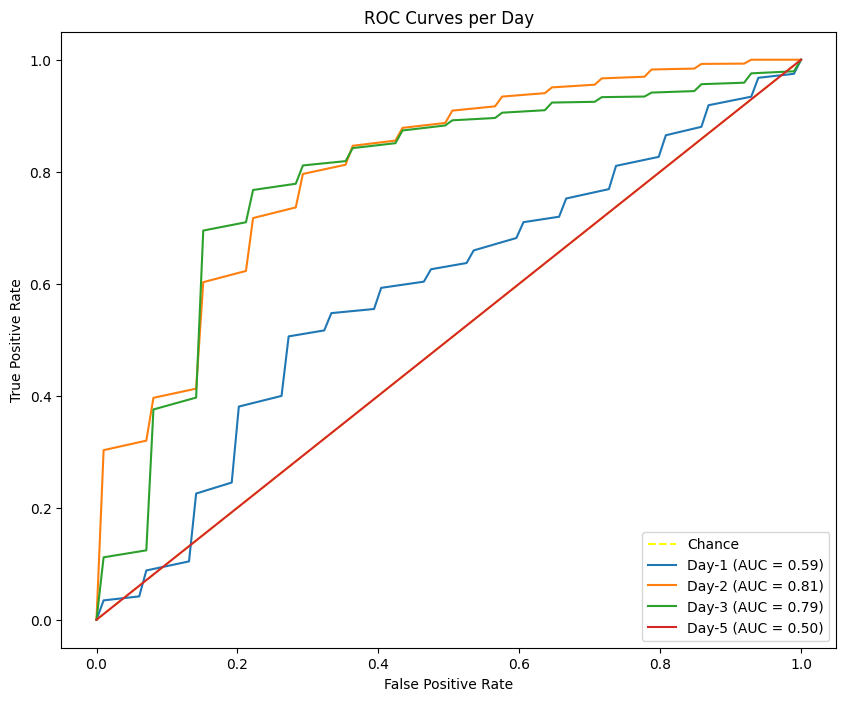

In [32]:
#Computing Bootstrapped AUC for VXA Test Days With Plotting
tr_x = clf_wcct.drop(['VOLUNTEER', 'DPC', 'SHEDDER'], axis=1)
tr_y = clf_wcct['SHEDDER']
plt.figure(figsize=(10, 8))
mean_fpr_grid = np.linspace(0, 1, 100)
# Mapping between normalized DAY values and real study days
# Normalized dataset contains days [2, 3, 5, 7]  → correspond to Day-1, Day-2, Day-3, Day-5
day_map = {2: 1, 3: 2, 5: 3, 7: 5}
# Loop through each normalized day actually present in VXA
plt.plot([0, 1], [0, 1], '--', color='yellow', label='Chance')
for d in [2, 3, 5, 7]:
    testx = clf_vxa[clf_vxa['DPC'] == d].drop(['VOLUNTEER', 'DPC', 'SHEDDER'], axis=1)
    testy = clf_vxa[clf_vxa['DPC'] == d]['SHEDDER']
    if testx.empty:
        continue
    aucs = []
    interp_tprs = []
    for i in range(100):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED+i)
        for tr_idx, _ in cv.split(tr_x, tr_y):
            RF = RandomForestClassifier(random_state=SEED+i)
            RF.fit(tr_x.iloc[tr_idx], tr_y.iloc[tr_idx])
            probs = RF.predict_proba(testx)[:,1]
        # Safe ROC computation even if only one class 
        if len(np.unique(testy)) < 2:
            fpr = np.linspace(0, 1, 100)
            tpr = fpr
            auc_val = 0.5
        else:
            fpr, tpr, _ = roc_curve(testy, probs)
            auc_val = roc_auc_score(testy, probs)
        interp_tpr = np.interp(mean_fpr_grid, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
        aucs.append(auc_val)
    mean_tpr = np.mean(interp_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    relabeled_day = day_map[d]
    plt.plot(mean_fpr_grid, mean_tpr,
             label=f'Day-{relabeled_day} (AUC = {mean_auc:.2f})')
plt.title('ROC Curves per Day')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Filter shedders 

In [33]:
wcct = wcct[(wcct['SHEDDER']==1)].copy()
wcct = wcct[(~wcct['VOLUNTEER'].isin([101,109,304]))].copy()
wcct.head()

,VOLUNTEER,DPC,SHEDDER,B.cells.plasma.STAT5+,Basophils,Bcells,Bcells.CSM,Bcells.NCSM,Bcells.plasma,CD66+,...,Tcells.CD8+,Tcells.CD8+.CD161+,Tcells.CD8+.CD38+,Tcells.CD8+.CD38+Ki67+,Tcells.CD8+.Effector.CD38+,Tcells.CD8+.Effector.CD38+Ki67+,Tcells.CD8+.Memory,Tcells.CD8+.Memory.CD38+,Tcells.CD8+.Memory.CD38+Ki67+,Tcells.CD8+CD45RA+CD27-
22,103,-1,1,-0.01082,0.19615,0.11614,-0.05478,-0.15203,-0.05689,0.017191,...,0.44948,0.13810,0.08234,0.01936,-0.00222,0.00328,0.07295,0.03072,0.03036,0.05632
24,103,1,1,-0.06215,-0.12480,-0.44558,-0.08182,-0.13088,-0.04950,-0.005263,...,-0.69512,0.26085,0.15328,0.04443,0.00979,0.01225,0.07332,0.09775,0.07290,-0.38460
25,103,2,1,-0.04160,0.02879,-0.01181,-0.11318,-0.09191,-0.05185,0.003941,...,-0.29205,0.23332,0.15224,0.03233,0.00589,0.00861,-0.00732,0.11616,0.03674,-0.15714
26,103,3,1,-0.05114,-0.16881,-0.29821,-0.19003,-0.14904,-0.11298,0.018437,...,-1.11903,0.08996,0.20048,0.12845,0.00492,0.00739,0.10997,0.17138,0.08224,-0.23637
27,103,4,1,-0.10856,-0.39151,-0.95248,-0.22691,-0.27057,-0.09219,-0.004700,...,0.08343,0.08246,0.39451,0.17163,0.02772,0.00670,0.24408,0.31168,0.12348,0.71900


In [34]:
vxa = vxa[vxa['SHEDDER']==1].copy()
vxa.head()

,VOLUNTEER,DPC,SHEDDER,B.cells.plasma.STAT5+,Basophils,Bcells,Bcells.CSM,Bcells.NCSM,Bcells.plasma,CD66+,...,Tcells.CD8+,Tcells.CD8+.CD161+,Tcells.CD8+.CD38+,Tcells.CD8+.CD38+Ki67+,Tcells.CD8+.Effector.CD38+,Tcells.CD8+.Effector.CD38+Ki67+,Tcells.CD8+.Memory,Tcells.CD8+.Memory.CD38+,Tcells.CD8+.Memory.CD38+Ki67+,Tcells.CD8+CD45RA+CD27-
0,107,-1,1,-0.02630,0.77783,1.02104,0.02631,0.08149,-0.03656,-0.146383,...,1.82062,1.05442,-0.02460,-0.09014,0.00040,0.00249,1.16451,-0.08425,-0.06471,-0.30631
2,107,1,1,-0.01609,0.02710,-0.17730,0.05713,-0.21647,-0.02352,0.053030,...,-0.10020,0.39986,-0.02916,-0.04844,-0.00010,0.00150,-1.98972,-0.05709,-0.05614,0.58016
3,107,2,1,-0.01983,-0.04950,-1.55738,-0.22085,-0.37667,-0.02629,0.358937,...,-3.23430,-0.21429,-0.04153,-0.05820,-0.00169,0.00135,-3.31334,-0.05766,-0.06038,0.69410
4,107,3,1,-0.02780,0.13281,-2.13893,-0.32833,-0.55963,-0.03839,0.176420,...,-4.46944,-0.12235,-0.01474,-0.04988,-0.00169,0.00635,-4.59918,-0.02814,-0.05340,0.23712
5,107,5,1,-0.02692,-0.31642,-1.88563,-0.45649,-0.52217,-0.03722,-0.561544,...,-2.75483,0.05773,0.04273,0.00844,0.00663,0.01615,-0.86812,0.04251,0.05327,0.01326


### Filter unwanted days out

In [35]:
tr_days = [1,2,3,4,5,6,7,8]
rg_wcct = wcct[(wcct['DPC'].isin(tr_days)) ]
rg_vxa = vxa[(vxa['DPC'].isin(tr_days))]

## Random Forest Regressor

In [36]:
regr = RandomForestRegressor(random_state = SEED)
trus = []
preds = []
to_write = pd.DataFrame()
X_tr = rg_wcct.drop(['VOLUNTEER','DPC', 'SHEDDER'], axis =1)
Y_tr = rg_wcct['DPC']
clf = regr.fit(X_tr, Y_tr)
vxa_ids = sorted(rg_vxa['VOLUNTEER'].unique())
vxa_days = sorted(rg_vxa['DPC'].unique())
for n,id_ in enumerate(vxa_ids):
    for d in vxa_days:
        test = rg_vxa[(rg_vxa['VOLUNTEER']==id_) & (rg_vxa['DPC']==d)]#.sample(n=1)
        X_te = test.drop(['VOLUNTEER','DPC', 'SHEDDER'], axis =1)
        Y_te = test['DPC']
        if test.empty:
            continue
        pr = regr.predict(X_te)
        trus.extend(Y_te.values)
        preds.extend(pr)
        dic_ = {}
        dic_['iteration'] = d
        dic_['ID'] = id_
        dic_['true'] = Y_te.values
        dic_['predicted'] = pr
        to_write = pd.concat([to_write, pd.DataFrame([dic_])], ignore_index=True)
correlation, p_value = stats.pearsonr(trus,preds)
correlation, p_value

(0.7276186771816391, 9.685982542821127e-14)

### Scatter Plot of True vs Predicted values
### Median Line, regression line, 95% confidence Interval, Pearson correlation coefficient and p-value

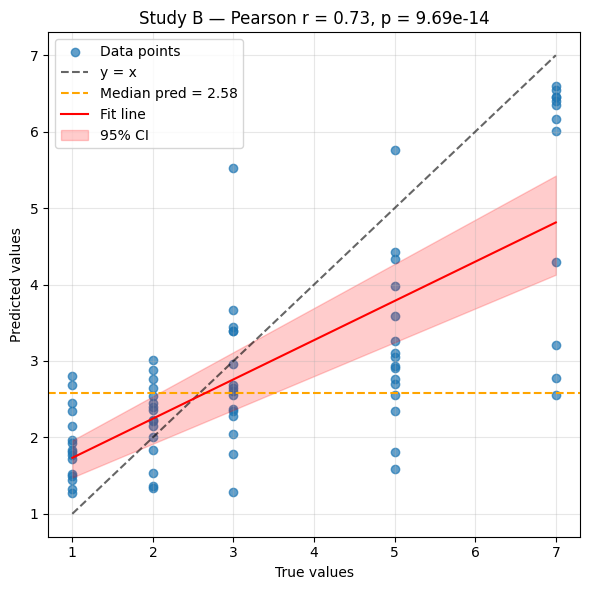

In [37]:
def plot_scatter_with_ci(y_true, y_pred, n_bootstrap=1000):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    r, p = stats.pearsonr(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.7, label="Data points")
    lims = [1, 7]
    plt.plot(lims, lims, 'k--', alpha=0.6, label="y = x")
    median_pred = np.median(y_pred)
    plt.axhline(median_pred, color="orange", linestyle="--", label=f"Median pred = {median_pred:.2f}")
    slope, intercept, _, _, _ = stats.linregress(y_true, y_pred)
    line = slope * np.array(lims) + intercept
    plt.plot(lims, line, color="red", label="Fit line")
    boot_lines = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        s, i, _, _, _ = stats.linregress(y_true[idx], y_pred[idx])
        boot_lines.append(s * np.array(lims) + i)
    boot_lines = np.array(boot_lines)
    low_line = np.percentile(boot_lines, 2.5, axis=0)
    high_line = np.percentile(boot_lines, 97.5, axis=0)
    plt.fill_between(lims, low_line, high_line, color="red", alpha=0.2, label="95% CI")
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title(f"Study B — Pearson r = {r:.2f}, p = {p:.2e}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0.7, 7.3)
    plt.ylim(0.7, 7.3)
    plt.xticks(range(1, 8))
    plt.yticks(range(1, 8))
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    plot_scatter_with_ci(trus, preds)

### rMSE
### preds:list of predicted days
### trus:list of true days

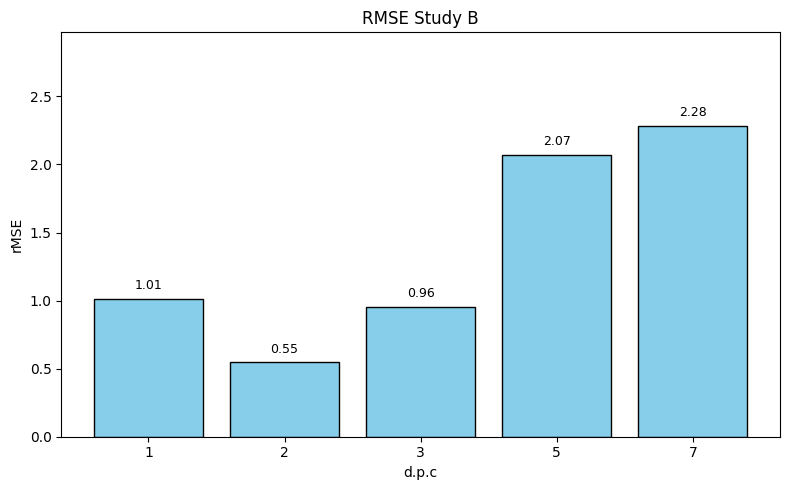

In [38]:
def plot_daywise_rmse(preds, trus):
    preds = np.array(preds)
    trus = np.array(trus)
    expected_days = sorted(list(set(np.round(trus).astype(int))))
    rmses = []
    for d in expected_days:
        mask = np.isclose(trus, d, atol=0.1)  
        if mask.sum() == 0:
            rmses.append(np.nan)  # empty bar if any DAY is empty
            continue
        rmse = np.sqrt(np.mean((preds[mask] - trus[mask]) ** 2))
        rmses.append(rmse)
    labels = [str(int(d)) for d in expected_days]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, rmses, color="skyblue", edgecolor="black")
    plt.ylabel("rMSE")
    plt.xlabel("d.p.c")
    plt.title("RMSE Study B")
    plt.ylim(0, np.nanmax(rmses) * 1.3)
    for bar, val in zip(bars, rmses):
        if np.isnan(val):
            continue
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f"{val:.2f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()
plot_daywise_rmse(preds, trus)

### Heatmap Study B
### Predicted vs actual DPC by Subject

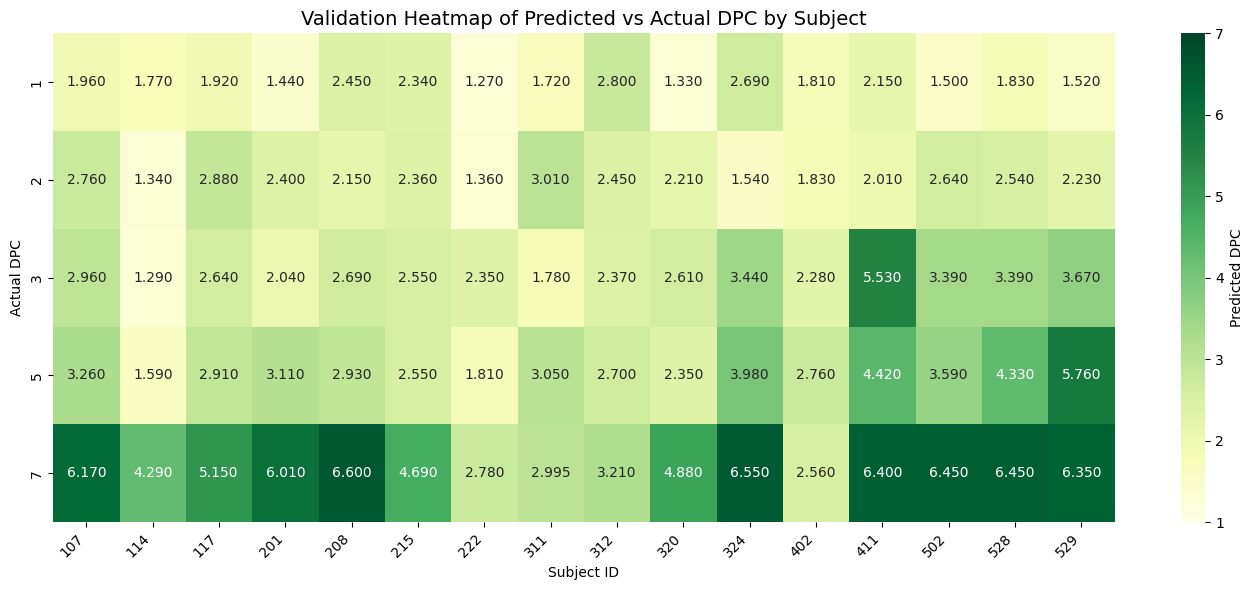

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
if 'rg_vxa' not in globals():
    tr_days = [1,2,3,4,5,6,7,8]
    rg_vxa = vxa[vxa['DPC'].isin(tr_days)].copy()
X_val = rg_vxa.drop(['VOLUNTEER','DPC','SHEDDER'], axis=1)
y_true = rg_vxa['DPC'].values
ids = rg_vxa['VOLUNTEER'].astype(str).values  
y_pred = clf.predict(X_val)
actual_dpc = y_true
pred_dpc = y_pred
mask = (actual_dpc >= 1) & (actual_dpc <= 7)
df = pd.DataFrame({
    "SubjectID": ids[mask],
    "Actual_DPC": actual_dpc[mask],
    "Predicted_DPC": pred_dpc[mask]
})
heatmap_df = pd.pivot_table(
    df,
    index="Actual_DPC",
    columns="SubjectID",
    values="Predicted_DPC",
    aggfunc="median"      
)
heatmap_df = pd.pivot_table(
    df,
    index="Actual_DPC",
    columns="SubjectID",
    values="Predicted_DPC",
    aggfunc="median"
)
heatmap_df = heatmap_df.interpolate(axis=1, limit_direction="both")
heatmap_df = heatmap_df.interpolate(axis=0, limit_direction="both")
heatmap_df = heatmap_df.fillna(heatmap_df.mean(numeric_only=True))
heatmap_df = heatmap_df.sort_index()
try:
    heatmap_df = heatmap_df.reindex(sorted(heatmap_df.columns, key=lambda x: int(x)), axis=1)
except Exception:
    heatmap_df = heatmap_df.reindex(sorted(heatmap_df.columns), axis=1)
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    heatmap_df,
    vmin=min(df["Actual_DPC"]), vmax=max(df["Actual_DPC"]),
    cmap="YlGn",
    annot=True, fmt=".3f",
    cbar_kws={"label": "Predicted DPC"})
ax.set_title("Validation Heatmap of Predicted vs Actual DPC by Subject", fontsize=14)
ax.set_xlabel("Subject ID")
ax.set_ylabel("Actual DPC")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()